In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

all_data = pd.read_csv("data/estonia-passenger-list.csv")

In [3]:
anonymized_data = all_data.drop(["Firstname", "Lastname", "PassengerId"], axis=1)

In [4]:
anonymized_data.Country = anonymized_data.Country.map(
    lambda x: x if x == "Estonia" or x == "Sweden" else "Other"
)

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

data_train, data_test, y_train, y_test = train_test_split(
    anonymized_data.drop(["Survived"], axis=1),  # X
    anonymized_data["Survived"],  # y
    test_size=0.3,  # доля от всех записей
    random_state=322,  # зерно
    stratify=anonymized_data["Survived"],
)

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse as sp


# Не все классификаторы умеют обращаться с категориальными признаками.
def prepare_features_for_logreg(data: pd.DataFrame, cat_encoder=None, real_scaler=None):
    cat_columns = ["Country", "Sex", "Category"]
    real_columns = ["Age"]

    # categorical features
    if cat_encoder is None:
        ohe = OneHotEncoder(handle_unknown="ignore")
        ohe.fit(data[cat_columns])
    else:
        ohe = cat_encoder
    X_cat = ohe.transform(data[cat_columns])
    cat_fnames = ohe.get_feature_names_out(cat_columns)

    # real-valued features
    if real_scaler is None:
        stsc = StandardScaler()
        stsc.fit(data[real_columns])
    else:
        stsc = real_scaler
    X_real = stsc.transform(data[real_columns])
    feature_matrix = sp.hstack([X_cat, X_real])

    return feature_matrix, list(cat_fnames) + real_columns, ohe, stsc


X_train_sparse, fnames_sparse, encoder_sparse, scaler = prepare_features_for_logreg(
    data_train
)
X_test_sparse, _, _, _ = prepare_features_for_logreg(data_test, encoder_sparse, scaler)

In [15]:
print(X_train_sparse.shape)

(692, 8)


In [9]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

param_grid = [
    {
        "svd__n_components": [1, 2, 4, 6],
        "svd__n_iter": [5, 100, 1000],
        "RFC__max_depth": [1, 3, 5],
        "RFC__n_estimators": [1, 5, 10],
        "RFC__random_state": [42],
    }
]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

# Tuning for accuracy

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=5; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=5; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=5; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=100; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=100; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=100; total time=   0.0s
[CV] END RFC__max_depth=1, RFC__n_estimators=1, RFC__random_state=42, svd__n_components=1, svd__n_iter=1000; total time=   0.2s
[CV] END RFC__max_depth=1, RFC

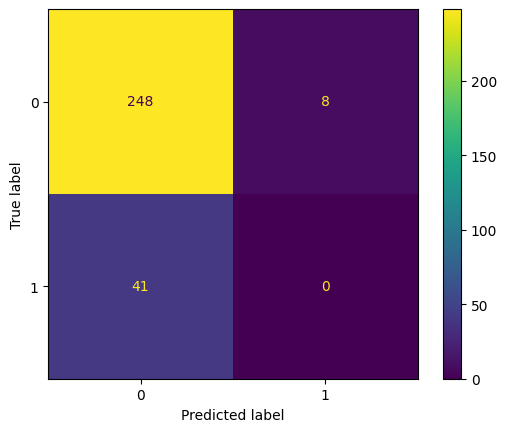

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.59s/it]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.decomposition import TruncatedSVD

scores = ["accuracy"]

for score in tqdm(scores):
    print("# Tuning for %s" % score)
    print()

    pipe = Pipeline(steps=[("svd", TruncatedSVD()), ("RFC", RandomForestClassifier())])
    clf = GridSearchCV(pipe, param_grid, scoring=score, verbose=2, cv=3)
    clf.fit(X_train_sparse, y_train)

    print("Best params on dev set:")
    print(clf.best_params_)

    print("Scores on development set:")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]

    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    best_model = clf.best_estimator_
    best_model.fit(X_train_sparse, y_train)

    y_true, y_pred = y_test, best_model.predict(X_test_sparse)

    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))

    disp.plot()
    plt.show()